## Initializing a source and starting to simulate


### General Structure: 
 The general structure of the program is to,
 1. Initialize a source object **S**.
 2. Then the source object will get passed on to the simulation object **Sim**. 
 3.  Finally the visual object **V** will get defined, using the simulation object as input. 

This way, the general structure is **S $\rightarrow$ Sim $\rightarrow$ V $\rightarrow$ output**

### This example
* We consider the one temperature model, only electron temperature first and then also include the  lattice temperature. 
* A laser pulse, with Gaussian time profile a local absorption profile computed with the Transfer Matrix Method is taken into account.
* We consider a layer stack of [Platinum|Cobalt|Chromium] 

In [6]:
from NTMpy import NTMpy as ntm
from matplotlib import pyplot as plt
import numpy as np
import numericalunits as u
u.reset_units('SI')

Setting up the Source. 
* `s.spaceprofile = "TMM"` for Transfer Matrix Method or `"LB"` for the Lambert Beer Law
* `s.timeprofile = "Gaussian"` or `repGaussian` for repeated gaussian or `Custom` where an array of data points in time are considered, once provided to the object. 

To see further examples vist our [wiki](https://github.com/udcm-su/NTMpy/wiki). 

In [7]:
#Define a Source
s              = ntm.source()
s.spaceprofile = "TMM" 
s.timeprofile  = "Gaussian"
s.FWHM         = 0.3*u.ps             #Full width half max of the laser pulse
s.fluence      = 15*u.mJ/u.cm**2    #Fluence of the laser
s.t0           = 1*u.ps             #Time when Gaussian peaks
s.lambda_vac   = 400                #Wavelength of incident light (in nm!)
s.theta_in     = np.pi/4            #Incident angle
s.polarization = "p"

Considering the one temperature model.
We set up a simulation object **sim** and provide the material specific parameters.

I.e. length of material,complex refractive index, heat conductivity $k_i(T(x,t))$, heat Capacity $C_i(T(x,t))$, density of material $\rho_i$. 
Note, that $k_i$ and $C_i$ can be both be, a function of the temperature or a constant. 

In [8]:
#Platinum
length_Pt   = 3*u.nm #Length of the Material
n_Pt        = 1.0433+3.0855j #Complex refractive index
k_el_Pt     = 73*u.W/(u.m*u.K);#Heat conductivity
rho_Pt      = 1e3*21*u.kg/(u.m**3)#Density
C_el_Pt     = lambda Te: (740*u.J/(u.m**3*u.K**2))/(1e3*21*u.kg/(u.m**3)) *Te #Electron heat capacity
C_lat_Pt    = 2.8e6*u.J/(u.m**3*u.K**2)/rho_Pt#Lattice heat capacity
G_Pt        = 1e16*25*u.W/(u.m**3*u.K)        #Lattice electron coupling constant
#Cobalt
length_Co   = 15*u.nm;  
n_Co        = 1.0454+3.2169j
k_el_Co     = 100*u.W/(u.m*u.K);
rho_Co      = 1e3*8.86*u.kg/(u.m**3)
C_el_Co     = lambda Te: (704*u.J/(u.m**3*u.K**2))/(1e3*8.86*u.kg/(u.m**3)) *Te
C_lat_Co    = 4e6*u.J/(u.m**3*u.K**2)/rho_Co
G_Co        = 1e16*93*u.W/(u.m**3*u.K)

In [9]:
#1 Temperature model: Set up simulation 
#Define numer of coupled systems taken into consideration 
#Pass on the source object s as an input parameter
sim = ntm.simulation(1,s) 
#add layers (Length,n,conductivity,heatCapacity,density)
sim.addLayer(length_Pt,n_Pt,[k_el_Pt],[C_el_Pt],rho_Pt) #Platinum 
sim.addLayer(length_Co,n_Co,[k_el_Co],[C_el_Co],rho_Co) #Cobalt
sim.final_time = 7*u.ps                                 #Final time of the simulation

In order to get the data output, one just has to execute the following command. 

In [10]:
#To get the raw output
[x,t,T] = sim.run() 

-----------------------------------------------------------
 No specific time constant has been indicated. 
 The stability region has been calculated and an appropriate timestep has been chosen.
 Timestep = 4.77e-17 s
-----------------------------------------------------------
-----------------------------------------------------------
Transfer matrix absorption profile and a Gaussian time profile is taken into account for the source.
Length of every layer has to be given in units of meter.
-----------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████| 146859/146859 [00:23<00:00, 6261.46it/s]


-----------------------------------------------------------
Electron temperature heat diffusion has been simulated.
Eleapsed time in E.E.- loop: 23.564008712768555
-----------------------------------------------------------


No specific time step for the simulation needs to be given (but can be, via `sim.time_step = float `). We estimate the stability region for the Explicit Euler method automatically and run it according to that.
However sometimes one wants to capture fast dynamics explicitly, which is why `sim.time_step = float ` is integrated.
In the box above, `T` is a matrix, giving the temperature evolution in time and space *(a method of lines approach is used)*. `x` and `t` are the space and time grid respectively.

In order to quickly show results, we also provide a ready made visualization class: **V**. 

Here **Sim** needs to be given as an input argument. 

In [11]:
#Visualize result
#Create a visual object where the simulation gets passed on 
v  = ntm.visual(sim)

------------------------------------------------------------
The simulation object of the 1 temerature system has been passed on to the visual class.
------------------------------------------------------------
-----------------------------------------------------------
Transfer matrix absorption profile and a Gaussian time profile is taken into account for the source.
Length of every layer has to be given in units of meter.
-----------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████| 146859/146859 [00:20<00:00, 7034.45it/s]


-----------------------------------------------------------
Electron temperature heat diffusion has been simulated.
Eleapsed time in E.E.- loop: 20.877105951309204
-----------------------------------------------------------


-----------------------------------------------------------
Transfer matrix absorption profile and a Gaussian time profile is taken into account for the source.
Length of every layer has to be given in units of meter.
-----------------------------------------------------------


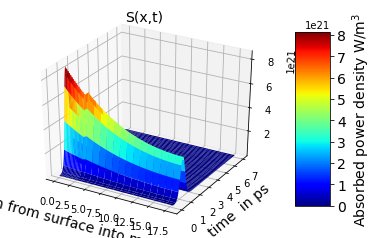

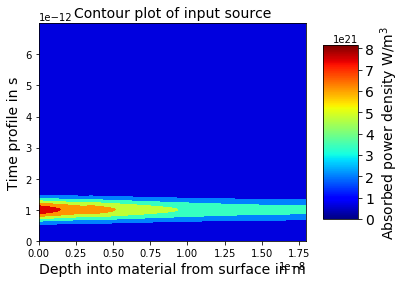

In [12]:
#output of v.source is the full matrix of the source(x,t)
so = v.source()

Note that the output of `so = v.source()` is the full matrix of the source input. We recommend to check if the shape is what the user would expect, since the source term really is one of the main influencing factors of the overal dynamics. 
In this example we consider the Transfer Matrix representation, such that we take multiple reflections on layer boundaries into account. 

Now let us look at the full heat map in time and space and at an averaged (weighted with respect to the length of the material) plot.

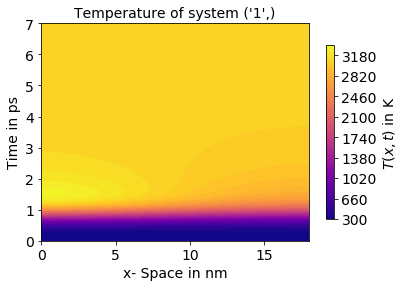

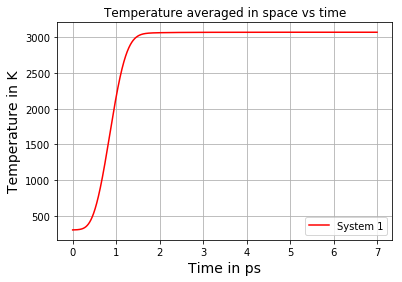

In [13]:
#A contourplot of system "1"
v.contour('1')
#System 1 temperature averaged over space vs time.
[t,avT]=v.average()

In order to see an animation of the dynamics one can simply execute `v.animation(speed,save)`.

Note, that the only if `save = 1` the animation gets saved. This will also require a [download](https://m.wikihow.com/Install-FFmpeg-on-Windows) of the ffmpeg movie writer. 

Simulation of a 1-temperature system


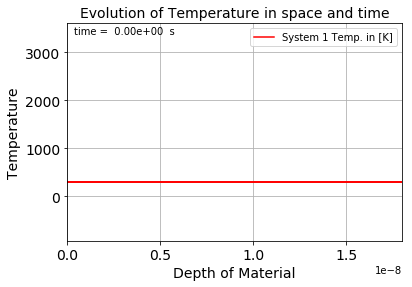

In [14]:
#Animation of dynamics
#animate the result input parameter is the speed of the animation
speed = 1
v.animation(speed)

### 2 Temperature example
In order to do simulate two system dynamics, here electron and lattice, we only modify the **Sim** object. 
Now we have to provide the object three additional parameters, i.e. the conductivity of the lattice system for every layer under consideration $k_i^L(T^L(x,t))$ the capacity of the lattic system $C_i^L(T^L(x,t))$ and the coupling constant $G_i$ which denotes the strength of the coupling between both systems. ($G_i\cdot(T^L-T^E)$ for the electron system and $G_i\cdot(T^E-T^L)$ for the lattice system in every layer $i = 1,2,...$).

In [15]:
#Temperature Model: 
#Two temperatures are considered, electron and lattice
sim = ntm.simulation(2,s)
#add parameters for both layers and both systems
sim.addLayer(length_Pt,n_Pt,[k_el_Pt,k_el_Pt],[C_el_Pt,C_lat_Pt],rho_Pt,[G_Pt])  
sim.addLayer(length_Co,n_Co,[k_el_Co,k_el_Co],[C_el_Co,C_lat_Co],rho_Co,G_Co) 
sim.final_time = 7*u.ps
#To get the raw output
[x,t,T] = sim.run() 

-----------------------------------------------------------
 No specific time constant has been indicated. 
 The stability region has been calculated and an appropriate timestep has been chosen.
 Timestep = 4.77e-17 s
-----------------------------------------------------------
-----------------------------------------------------------
Transfer matrix absorption profile and a Gaussian time profile is taken into account for the source.
Length of every layer has to be given in units of meter.
-----------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████| 146864/146864 [00:46<00:00, 3172.67it/s]


-----------------------------------------------------------
Heat diffusion in a coupled electron-lattice system has been simulated
Eleapsed time in E.E.- loop: 46.290294885635376
-----------------------------------------------------------


As above, to get the raw output of the data, one has to execute `[x,t,T] = sim.run()`, where `T` is an array containing two matrices with the evolution of the electron, system 1 and the lattice, system 2, temperature in 1D space and time. `x` and `t` are the output of the space and the time grid respectively.
As before we can use the implemented visualization tools, to quickly depict the obtained solution. 

In [16]:
#Visualize result
#Create a visual object where the simulation gets passed on 
v = ntm.visual(sim)

------------------------------------------------------------
The simulation object of the 2 temerature system has been passed on to the visual class.
------------------------------------------------------------
-----------------------------------------------------------
Transfer matrix absorption profile and a Gaussian time profile is taken into account for the source.
Length of every layer has to be given in units of meter.
-----------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████| 146864/146864 [00:50<00:00, 2910.57it/s]


-----------------------------------------------------------
Heat diffusion in a coupled electron-lattice system has been simulated
Eleapsed time in E.E.- loop: 50.45885419845581
-----------------------------------------------------------


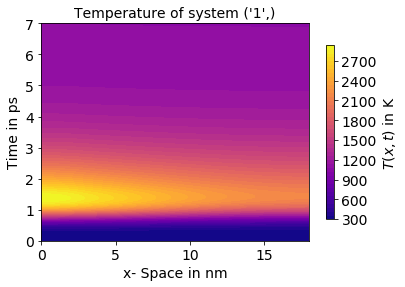

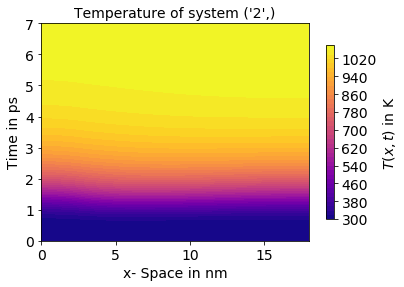

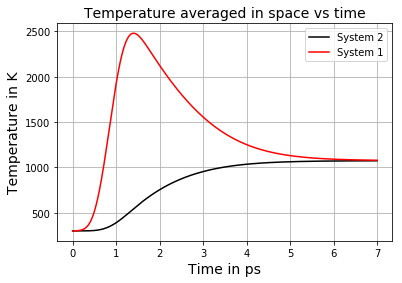

In [17]:
#A contourplot of the electron system
v.contour('1')
#This will only work in the two temperature case.
v.contour('2') 
[timegrid, avT] = v.average()


Simulation of a 2- temperature system


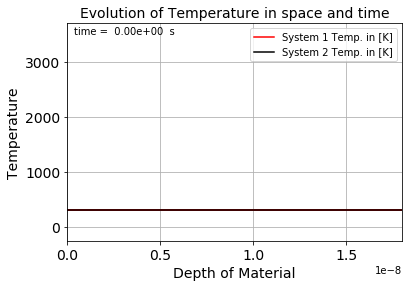

In [18]:
#animate the result input parameter is the speed of the animation
v.animation(speed)

Of course input parameters can be changed and modified according to individual simulation experiments. Examples on that will be shown in the [Wiki page](https://github.com/udcm-su/NTMpy/wiki) of the GitHub. 